In [1]:
from skimage import io
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import urllib.request as urllib
from io import StringIO, BytesIO

from tensorflow.contrib.slim.nets import inception
slim = tf.contrib.slim
%matplotlib inline

In [2]:
tf.flags.DEFINE_string(
    'master', '', 'The address of the TensorFlow master to use.'
)

tf.flags.DEFINE_string(
    'checkpoint_path', '', 'Path to checkpoint for inception network.')

tf.flags.DEFINE_string(
    'input_dir', '', 'Input directory with images.')

tf.flags.DEFINE_string(
    'output_dir', '', 'Output directory with images.')

tf.flags.DEFINE_integer(
    'batch_size', 1, 'How many images process at one time.')

FLAGS = tf.flags.FLAGS

In [3]:
DATASET_FOLDER = 'dataset'
DEV_DATASET_CSV = os.path.join(DATASET_FOLDER, 'dev_dataset.csv')
IMAGES_FOLDER = os.path.join(DATASET_FOLDER, 'images')

In [4]:
df = pd.read_csv(DEV_DATASET_CSV)
df.head(5)

,ImageId,URL,x1,y1,x2,y2,TrueLabel,TargetClass,OriginalLandingURL,License,Author,AuthorProfileURL
0,0c7ac4a8c9dfa802,https://c1.staticflickr.com/9/8540/28821627444...,0.000000,0.0,0.871838,1.000000,306,779,https://www.flickr.com/photos/gails_pictures/2...,https://creativecommons.org/licenses/by/2.0/,gailhampshire,https://www.flickr.com/people/gails_pictures/
1,f43fbfe8a9ea876c,https://c1.staticflickr.com/9/8066/28892033183...,0.250000,0.0,1.000000,0.599758,884,378,https://www.flickr.com/photos/barty/28892033183,https://creativecommons.org/licenses/by/2.0/,Barry Badcock,https://www.flickr.com/people/barty/
2,4fc263d35a3ad3ee,https://c1.staticflickr.com/8/7378/27465801596...,0.333333,0.0,1.000000,1.000000,244,123,https://www.flickr.com/photos/foxcroftacademy/...,https://creativecommons.org/licenses/by/2.0/,Foxcroft Academy,https://www.flickr.com/people/foxcroftacademy/
3,cc13c2bc5cdd1f44,https://c1.staticflickr.com/9/8864/28546467522...,0.000000,0.0,0.500000,0.750000,560,741,https://www.flickr.com/photos/o_0/28546467522/,https://creativecommons.org/licenses/by/2.0/,Guilhem Vellut,https://www.flickr.com/people/o_0/
4,73a52afd2f818ed5,https://c1.staticflickr.com/6/5607/31066602702...,0.489195,0.0,1.000000,0.750000,439,696,https://www.flickr.com/photos/chemiebw/3106660...,https://creativecommons.org/licenses/by/2.0/,Chemie-Verb\303\244nde Baden-W\303\274rttemberg,https://www.flickr.com/people/chemiebw/


In [18]:
def make_filename(img_id):
    return img_id + '.png'

def make_filepath(img_id):
    return os.path.join(IMAGES_FOLDER, make_filename(img_id))

def open_img(img_id):
    filepath = make_filepath(img_id)
    return io.imread(filepath)

def get_image_and_target(num):
    line = df.ix[num]
    
    url = line['URL']
    img_id = line['ImageId']
    
    return open_img(img_id) / 256, line['TargetClass'], line['TrueLabel']

In [19]:
img, target, label = get_image_and_target(0)

In [21]:
target, label

(779, 306)

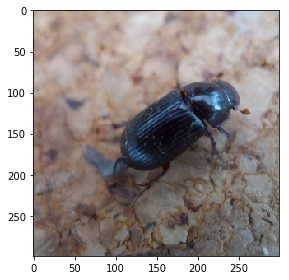

In [7]:
io.imshow(img)

In [8]:
target

779

In [15]:
class PushinMatyshin:
    def __init__(self):
        self.graph = tf.Graph()
        self.image_shape = (FLAGS.batch_size, 299, 299, 3)
        self.num_classes = 1001
        
        with self.graph.as_default():
            self.fake_image_subst = tf.Variable(
                np.zeros(self.image_shape, dtype=np.float32), name='fake_image_subst'
            )
            self.fake_image = (tf.tanh(self.fake_image_subst) + 1) / 2
            self.assign_fake_image_subs = self.fake_image_subst.assign(
                tf.atanh(2 * self.fake_image - 1)
            )
        
            with slim.arg_scope(inception.inception_v3_arg_scope()):
                self.fake_logits, self.inception_end_points = inception.inception_v3(
                    self.fake_image, num_classes=self.num_classes, is_training=False,
                )
                
            self.softmaxed_fake = tf.nn.softmax(self.fake_logits)
            self.top_classes = tf.nn.top_k(self.softmaxed_fake, 3)
        
            self.real_image = tf.placeholder(tf.float32, self.image_shape, name='real_image')
            self.assign_fake_image = self.fake_image_subst.assign(self.real_image)
            self.target_probs = tf.placeholder(
                tf.float32, [FLAGS.batch_size, self.num_classes], name='target_probs'
            )
            self.max_perturbation = tf.placeholder(tf.float32, (), name='max_perturbation')
            self.alpha = tf.placeholder(tf.float32, (), name='alpha')
            self.learning_rate = tf.placeholder(tf.float32, (), name='learning_rate')

            self.main_loss = tf.losses.softmax_cross_entropy(
                self.target_probs,
                self.fake_logits,
                label_smoothing=0.1,
                weights=1.0
            )
            

            self.abs_img_diff = tf.abs(self.fake_image - self.real_image)
            self.clipped_img_diff = tf.where(
                    self.abs_img_diff > self.max_perturbation,
                    self.abs_img_diff, tf.zeros(self.image_shape)
                )
            self.clipped_diff_sum = tf.reduce_sum(self.clipped_img_diff)
            self.reg_loss = self.alpha * self.clipped_diff_sum

            self.loss = self.main_loss + self.reg_loss

            start_vars = set(x.name for x in tf.global_variables())
            self.optimizer = tf.train.AdamOptimizer(self.learning_rate)
            
            self.train = self.optimizer.minimize(self.loss, var_list=[self.fake_image_subst])
            
            end_vars = tf.global_variables()
            new_vars = [x for x in end_vars if x.name not in start_vars]
            self.init = tf.variables_initializer(var_list=[self.fake_image_subst] + new_vars)

            saver = tf.train.Saver(slim.get_model_variables())
            session_creator = tf.train.ChiefSessionCreator(
                scaffold=tf.train.Scaffold(saver=saver),
                checkpoint_filename_with_path=FLAGS.checkpoint_path,
                master=FLAGS.master
            )
            self.sess = tf.train.MonitoredSession(session_creator=session_creator)
    
    def inference(self, images, targets, max_perturbation=15, alpha=1000, learning_rate=100, n=10):
        target_probs = np.zeros((len(targets), self.num_classes))
        max_perturbation /= 256
        
        for number, target in enumerate(targets):
            target_probs[number][target] = 1
        
        with self.graph.as_default():
            self.sess.run(self.init)
            result_images = self.sess.run(self.assign_fake_image, feed_dict={self.real_image: images})
            self.sess.run(self.assign_fake_image_subs)

            for i in range(n):
                result_images, loss, main_loss, reg_loss, softmaxed, fake_logits, top_classes, _ = self.sess.run(
                    [self.fake_image, self.loss, self.main_loss, self.reg_loss, self.softmaxed_fake, self.fake_logits, self.top_classes, self.train],
                    feed_dict={
                        self.real_image: images,
                        self.target_probs: target_probs,
                        self.max_perturbation: max_perturbation,
                        self.alpha: alpha,
                        self.learning_rate: learning_rate,
                    }
                )
                print(i, loss, main_loss, reg_loss, softmaxed, fake_logits, '\n', top_classes)
            else:
                return result_images, 0
            return result_images, loss

In [16]:
pm = PushinMatyshin()

In [17]:
result, loss = pm.inference([img], [target], alpha=100, learning_rate=0.01, n=100)

0 2.82754e+09 2.82135e+09 6.18701e+06 [[ 0.  0.  0. ...,  0.  0.  0.]] [[  1.60158320e+08  -2.18560512e+09   2.94258272e+08 ...,   1.55274611e+09
    8.35844224e+08   8.56087296e+08]] 
 TopKV2(values=array([[ 1.,  0.,  0.]], dtype=float32), indices=array([[790,   0,   1]], dtype=int32))
1 2.67523e+09 2.66904e+09 6.18558e+06 [[ 0.  0.  0. ...,  0.  0.  0.]] [[  1.73331696e+08  -2.14003059e+09   2.73065728e+08 ...,   1.52095923e+09
    8.00473664e+08   8.48409856e+08]] 
 TopKV2(values=array([[ 1.,  0.,  0.]], dtype=float32), indices=array([[790,   0,   1]], dtype=int32))
2 2.57589e+09 2.56971e+09 6.18235e+06 [[ 0.  0.  0. ...,  0.  0.  0.]] [[  1.84335024e+08  -2.11434752e+09   2.59523296e+08 ...,   1.50155648e+09
    7.79406336e+08   8.40760320e+08]] 
 TopKV2(values=array([[ 1.,  0.,  0.]], dtype=float32), indices=array([[790,   0,   1]], dtype=int32))
3 2.49853e+09 2.49235e+09 6.17966e+06 [[ 0.  0.  0. ...,  0.  0.  0.]] [[  1.90592880e+08  -2.09468621e+09   2.48757584e+08 ...,   1.487

In [ ]:
io.imshow(result[0])

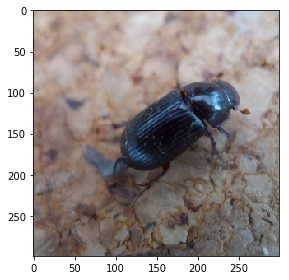

In [169]:
io.imshow(img)